# Interception of a target moving in a straight line

In this program I use Deep Deterministic Policy Gradient (DDPG) from this source: https://keras.io/examples/rl/ddpg_pendulum/ . I really advise to read it before working or learning my code. This implementation of the DDPG algorithm is written according to the article https://arxiv.org/pdf/1509.02971.pdf . For synthesis analytical trajectory I use the results obtained in this article https://arxiv.org/pdf/2102.04553.pdf . DDPG was applied for finding solution of the differential game of two cars, when target has rectilinear trajectory. The purpose of my work is to prove that neural networks can be used to solve differential games.

##### Import packages

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.path
import math
from tensorflow.keras.utils import plot_model
import pydot
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pylab
!pip install pyyaml h5py

You should consider upgrading via the 'c:\users\10\anaconda3\envs\tensorflow-sessions\python.exe -m pip install --upgrade pip' command.


In [16]:
import warnings
!git clone  https://github.com/shmax3/dubins
warnings.filterwarnings("ignore")

from numpy import array, sin, cos, sqrt, arctan, arccos, arctan2, roots, append, real, pi, inf
from scipy import integrate
#import special trajectories package
from dubins.planar_reachable_set import x_RS, y_RS, x_LR, y_LR, V_CS, V_CC_minus, V_CC_plus

#this formula is used for synthesis analytical trajectory
def arctg2(y, x):
    return (2 * (y >= 0) - 1) * arccos(x / sqrt(x ** 2 + y ** 2)) + 2 * (y < 0) * pi

"git" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


##### Initial conditions of the problem

In [17]:
#Dimension of State Space
dim_state = 3

#hidden_nodes = 3

#Time Difference Between 2 Steps
dt = 0.1

#Number of Episodes
num_episodes = 1000

#Number of Steps
num_steps = 400

#buffer_range = 60

#Minimum turing radius of Pursuer
rho = 1

#velocity of pursuer
v = 1.0

#Velocity of Evader during training
#ve = 0.5

#angle between initial velocity and reference
te = 3*np.pi/4

#here some notes about this problem for the future only for me
# способы обучения прямолинейного движения 
# 1) когда добавляем шум, близкие к 1 (или к -1) приравниваем к 1. То есть если выдает после шума 0.99, то приравниваем к 1
# 2) проверка до шума. Если алгоритм выдает 0 (или 1/-1) то оставлять это значение, а не добавлять шум

In [18]:
#define constants
pi = np.pi
R0 = 0.2 #intercept radius
ε = 0.001 #eps for definition of time

#initial coordinates of the target x0_e, y0_e
cor0 = (2.5, -1.5)
#here we can define them randomly
#cor0 = (np.random.uniform(-3,3) , np.random.uniform(-1,5)) #начальные координаты цели x0_e, y0_e (та же позиция, что и раньше)
cor0_e = cor0

#initial coordinates of the Dubins' car (next, just a car)
#cor0_e = [np.random.uniform(-3,3) , np.random.uniform(-1,5)] #начальные координаты цели x0_e, y0_e
cor0_p = [0, 0, pi/2]

#velocity of target
Vx_e = 0.5
Vy_e = 0.5
V_e = sqrt(Vx_e ** 2 + Vy_e ** 2) #abs velocity of target

#Trajectory E(x_E(t), y_E(t))
def xEn(t, cor0):
    return Vx_e * t + cor0[0]

def yEn(t, cor0):
    return Vy_e * t + cor0[1]

# state[0] - x_p
# state[1] - y_p
# state[2] - Phi for car
# state[3] - x_e
# state[4] - y_e

##### Define Neural Network

In [19]:
#Defining Function to add random noise (Ornstein-Uhlenbeck_process) in actions to increase Exploration
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.1, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [20]:
class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size
        #Buffer for critic / actor loss-function
        self.loss_critic = 0
        self.loss_actor = 0

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, dim_state))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, dim_state))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self):
        # Get the selection range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Random sample indexes
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
            
            self.loss_critic = critic_loss

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)
            
            self.loss_actor = actor_loss

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
    def get_list_critic(self):
        return self.loss_critic
    
    def get_list_actor(self):
        return self.loss_actor


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)

In [21]:
def get_actor():
    # Initialize weights between -3e-5 and 3-e5
    last_init = tf.random_uniform_initializer(minval=-0.00003, maxval=0.00003)

    inputs = layers.Input(shape=(dim_state,))
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs 
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(state_out)
    state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(action_input)
    action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [22]:
def policy(state, noise_object):
    
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)
    

    return [np.squeeze(legal_action)]

###### Begin construct NN and define required constants

In [23]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

# here we can print NN for a better understanding of its architecture

# actor_model = get_actor()
# actor_model.summary()
# plot_model(actor_model, to_file='actor_model.png')
# SVG(model_to_dot(actor_model).create(prog='dot', format='svg'))
# critic_model = get_critic()
# critic_model.summary()
# plot_model(critic_model, to_file='critic_model.png')

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models cr 0.0001 ac 0.00005
critic_lr = 0.0001
actor_lr = 0.00005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.98
# Used to update target networks
tau = 0.01

buffer = Buffer(10000, 64)

Now we introduce a formula for calculating the angle between the abscissa axis and the straight line connecting the coordinate points of the target and the pursuer. Let $(x_P, y_P)$ and $(x_E, y_E)$ be the coordinates of the pursuer and the target, respectively, at some point in time $t$. Then the desired value: $$\psi = \arctan{ \left( \frac{y_E - y_P}{x_E - x_P} \right)}.$$

We will also introduce a formula for calculating the distance $L$ between agents: $$L=\sqrt{(x_P-x_E)^2 + (y_P-y_E)^2}.$$

Next, to simplify the task, we will make the transition to reduced coordinates. To do this, you need the current state of the agents $S=(x_P, y_P, \varphi, x_E, y_E)$ and the state predicted by the neural network $S'=(x' _P, y' _P, \varphi', x'_E, y'_E)$.

We get the values for the functions of the angles $\psi$ and $\psi'$ from the states $S$ and $S'$, respectively, and also calculate the distance $L'$ when the agents are in the state $S'$. Next, we introduce the angle between the direction of the speed of the pursuer and the line connecting the coordinate points of the agents: $$\Theta=\varphi' - \psi'.$$

Now let's introduce the rotation speed as a quotient of the difference $\psi' - \psi$ and the time $\Delta t$ during which the transition from the state $S$ to the state $S'$ occurred:
$$\omega =\frac{\psi' - \psi}{\Delta t}.$$
    
The set of coordinates $(L', \omega, \Theta)$ and there are the desired reduced coordinates.
At the initial moment of time, when the result of the neural network has not yet been received, the reduced coordinates are calculated as follows:
\
    \begin{cases}
    L'=L(S)
    \\
    \omega = 0
    \\
    \Theta = \varphi(0) - \psi
    \end{cases}
    ,
    where $\psi = \arctan{ \left( \frac{y_E(0) - y_P(0)}{x_E(0) - x_P(0)} \right)}$.

It should be noted that when solving the problem, we will adhere to the following conditions:

1) The speed of the target does not exceed the modulus of the speed of the Dubins machine. Indeed, if the target has a speed significantly exceeding the value of the speed of the pursuer, then it is impossible to intercept with straight-line movement.

2) The presence of a predetermined interception radius $R_0$ - the maximum allowable distance between the pursuer and the target, at which the interception can be considered perfect. This parameter is introduced to define the concept of interception.

In [24]:
# the angle between the straight line connecting car and target and the X axis
def angle(state):
    return (math.atan2(state[4] - state[1],state[3] - state[0]) % (2*np.pi))

# length between car and target
def leng(state):
    length = ((state[0] - state [3])**2 + (state[1] - state[4])**2)**0.5
    return length

# reward function
def reward(state):
    r = -np.log(10 * leng(state)) - (leng(state))**2
    return r

# transition function from S state to S' state
# where state is S(x_P, y_P, Phi, x_E, y_E)
def transition(state, u , t , cor0):
    new_state = (state[0] + np.cos(state[2]) * dt , state[1] + np.sin(state[2]) *dt, (state[2] + u*dt) % (2*np.pi) , xEn(t+dt, cor0), yEn(t+dt , cor0))
    #new_state = (state[0] + (-1 + u*state[0] + np.cos(state[2])) * dt, state[1] + (-u*state[1] + np.sin(state[2])) * dt,state[2] + (1 - u  ) * dt)
    
    # the angle between the straight line connecting P and E and the axis OH
    alpha_0 = angle(state)
    # angle from the new position (new state)
    alpha = angle(new_state)
    #(Phi - alpha) -> "deflection angle (radial deflection) or phi" minus "the angle between the velocity and the X axis"
    red_tet = new_state[2] - alpha
    #reduced space / second term - angular velocity /
    #red_state = (leng(state), (alpha-alpha_0)/dt, red_tet)
    red_state = (leng(new_state), (alpha-alpha_0)/dt, red_tet)
    return new_state, red_state

Episode * 0 * Avg Reward is ==> -126108.69627547458


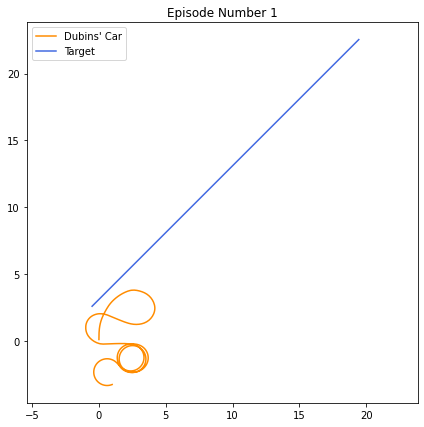

Episode * 1 * Avg Reward is ==> -135156.05206107255


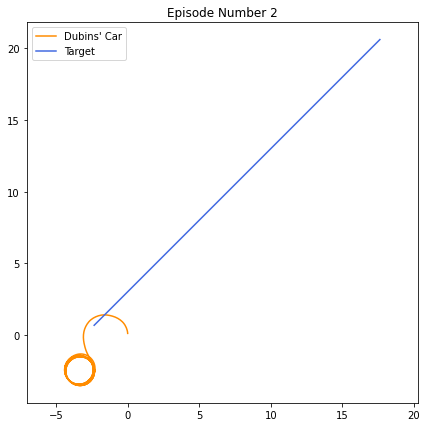

Episode * 2 * Avg Reward is ==> -110787.08850365815


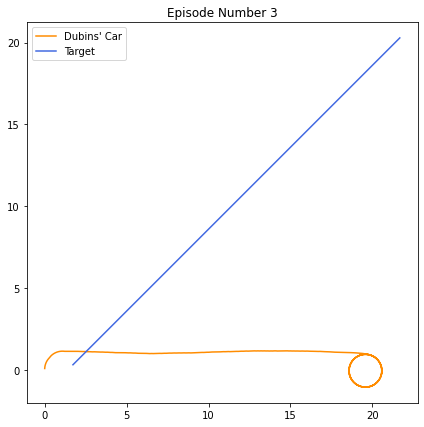

Episode * 3 * Avg Reward is ==> -107905.38665225566


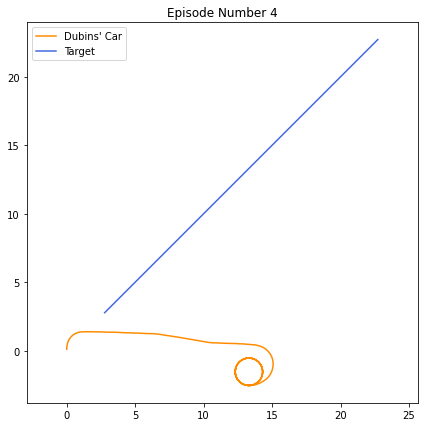

Episode * 4 * Avg Reward is ==> -117146.56823225501


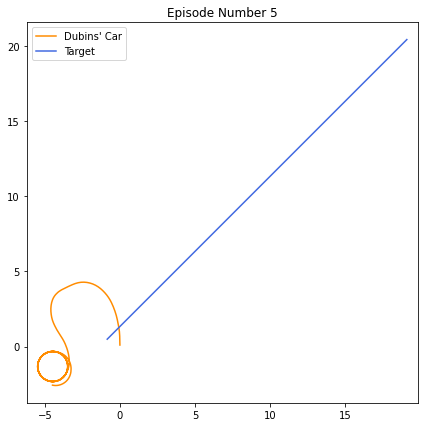

Episode * 5 * Avg Reward is ==> -107822.27668726636


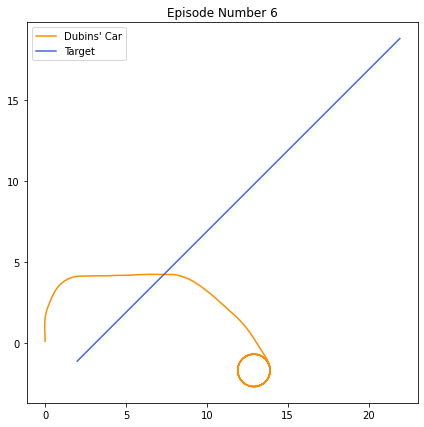

Episode * 6 * Avg Reward is ==> -103322.98339461272


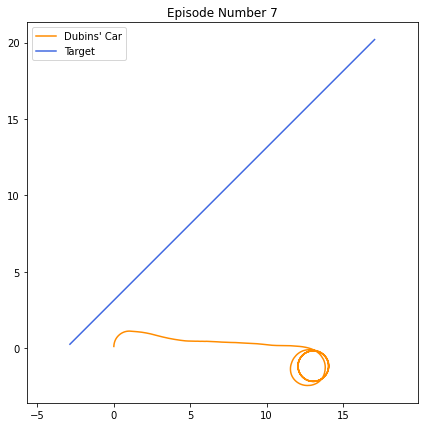

Episode * 7 * Avg Reward is ==> -99696.42587003487


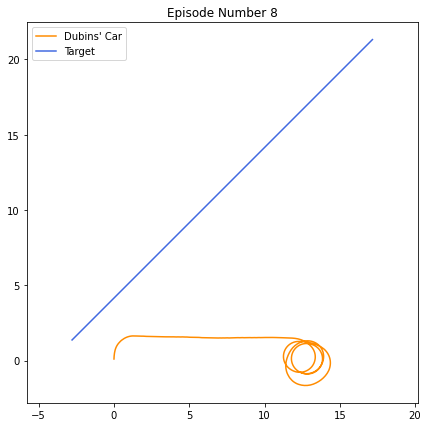

Episode * 8 * Avg Reward is ==> -102446.8631016448


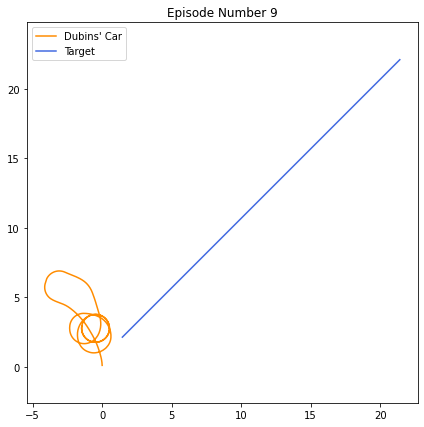

Episode * 9 * Avg Reward is ==> -113139.83038830811


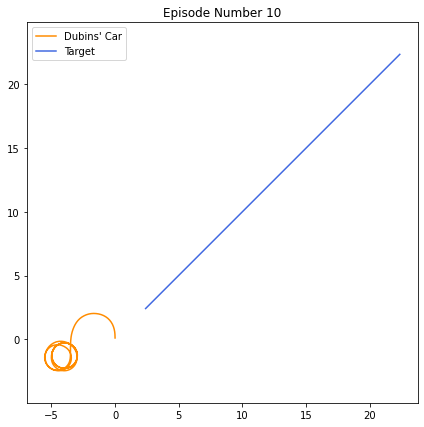

Episode * 10 * Avg Reward is ==> -108848.12908307249


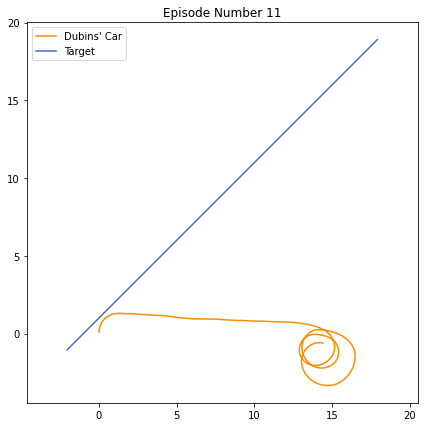

Episode * 11 * Avg Reward is ==> -107208.10980710847


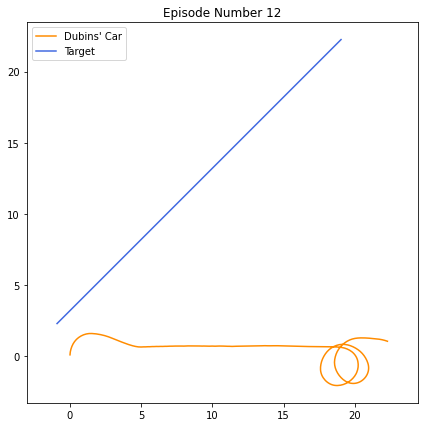

Episode * 12 * Avg Reward is ==> -104327.73767969674


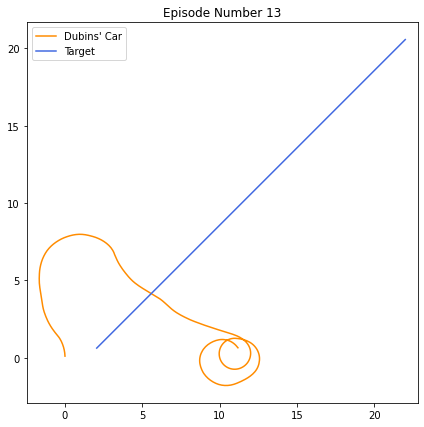

The target has been captured
Episode * 13 * Avg Reward is ==> -96885.418208445


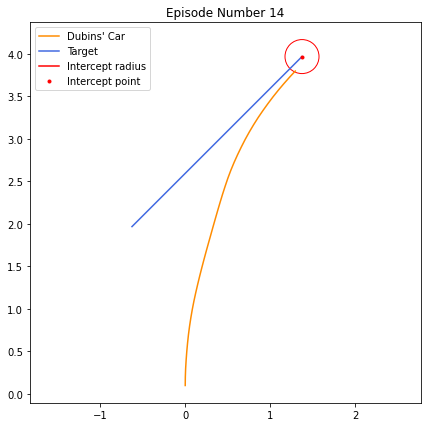

Episode * 14 * Avg Reward is ==> -98635.53110228843


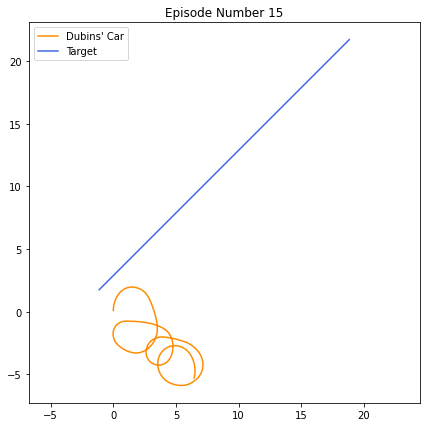

Episode * 15 * Avg Reward is ==> -95838.66331753385


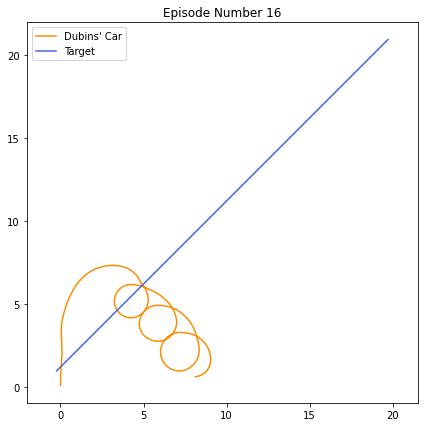

Episode * 16 * Avg Reward is ==> -94949.40502118149


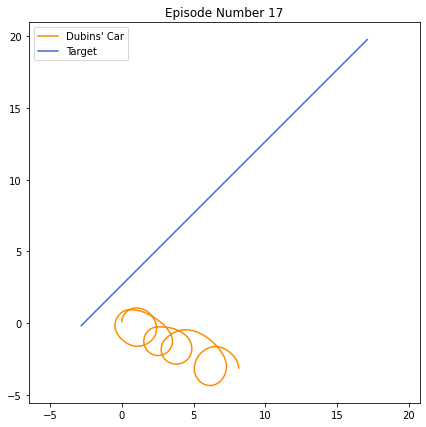

Episode * 17 * Avg Reward is ==> -92896.02437610237


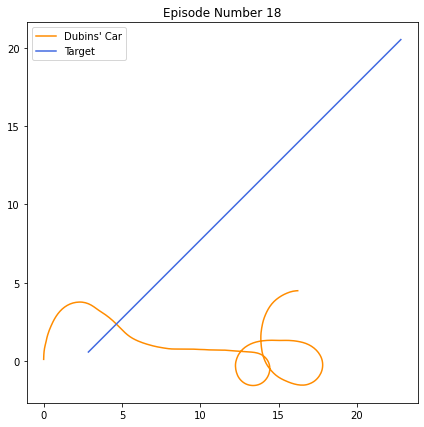

The target has been captured
Episode * 18 * Avg Reward is ==> -88117.67432580759


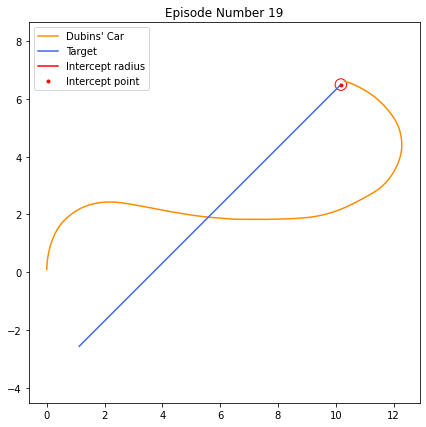

Episode * 19 * Avg Reward is ==> -85113.34656124574


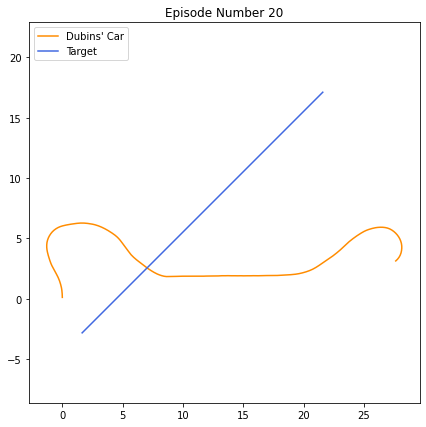

Episode * 20 * Avg Reward is ==> -82849.49453767315


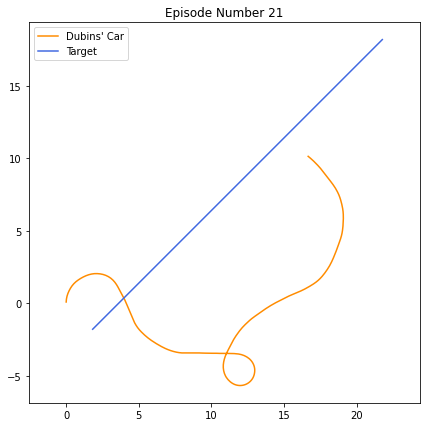

Episode * 21 * Avg Reward is ==> -81162.47185978563


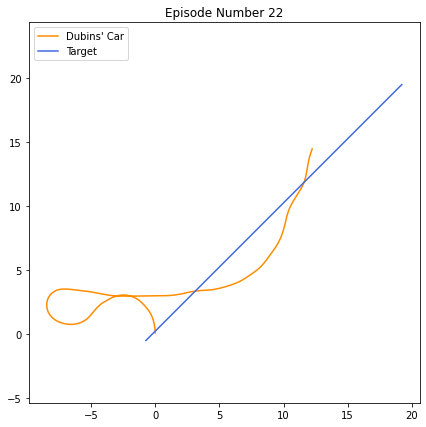

The target has been captured
Episode * 22 * Avg Reward is ==> -77957.0232935225


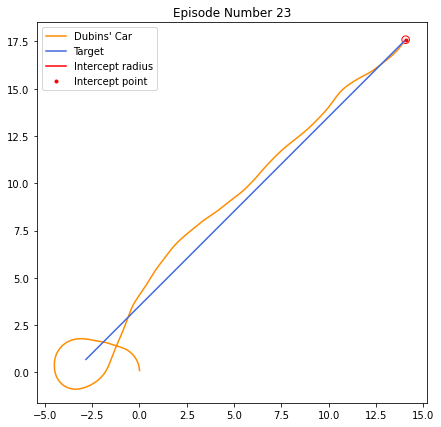

Episode * 23 * Avg Reward is ==> -74921.06279429594


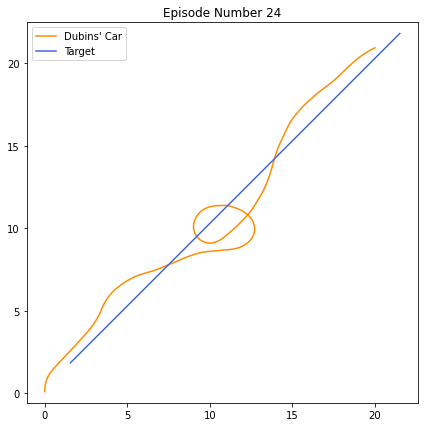

Episode * 24 * Avg Reward is ==> -72432.83207087664


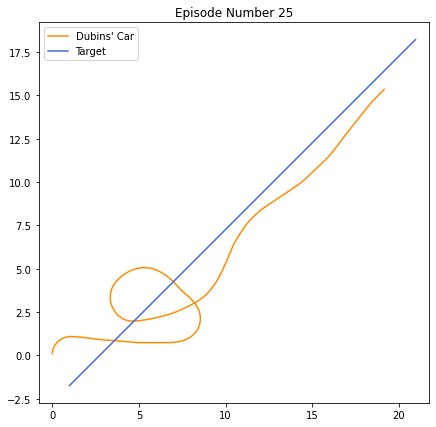

The target has been captured
Episode * 25 * Avg Reward is ==> -69758.15123499974


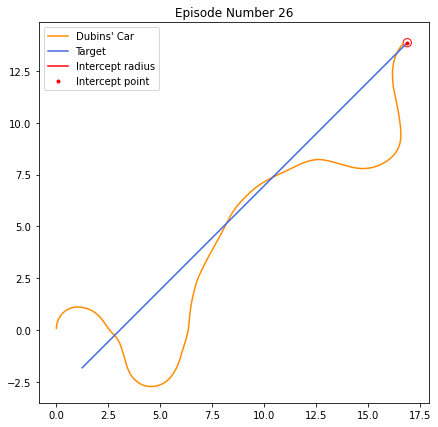

Episode * 26 * Avg Reward is ==> -67461.57853373364


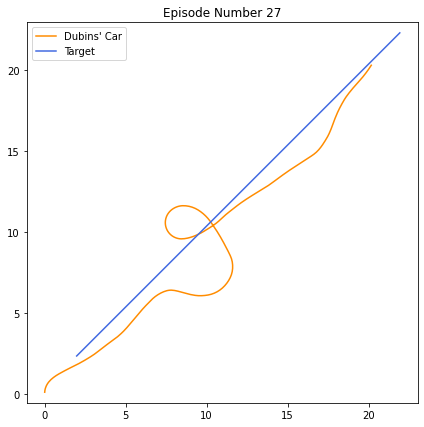

Episode * 27 * Avg Reward is ==> -65196.970446859035


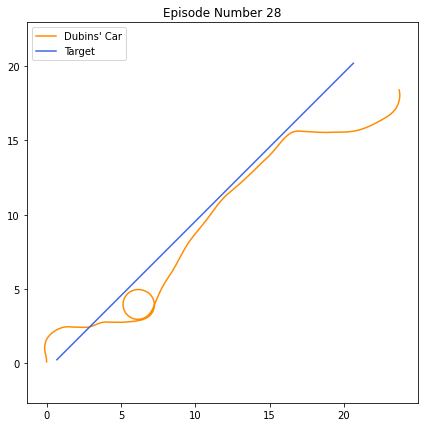

Episode * 28 * Avg Reward is ==> -63166.250021370404


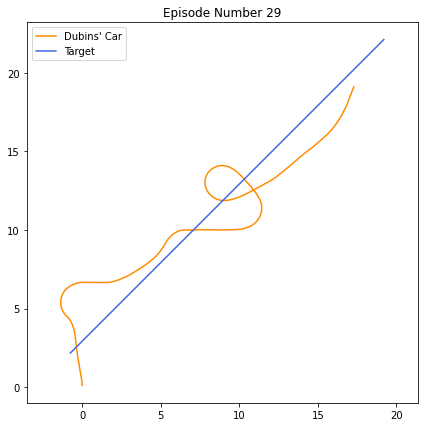

The target has been captured
Episode * 29 * Avg Reward is ==> -61085.60147438974


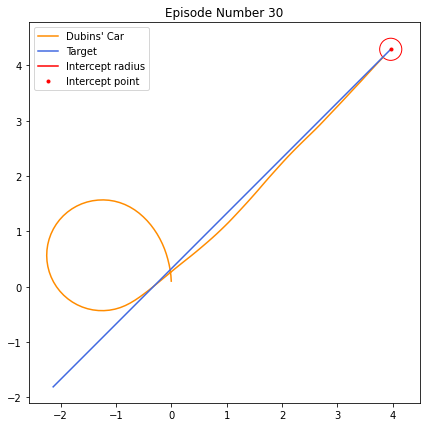

The target has been captured
Episode * 30 * Avg Reward is ==> -59182.73943397785


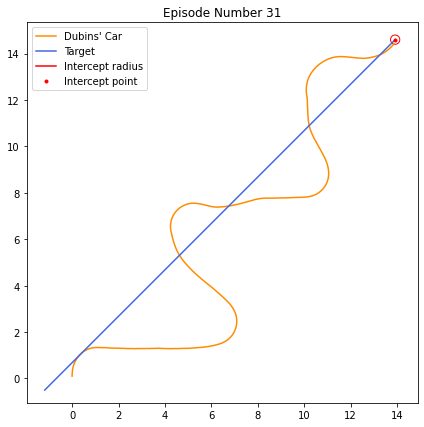

The target has been captured
Episode * 31 * Avg Reward is ==> -57351.17637279437


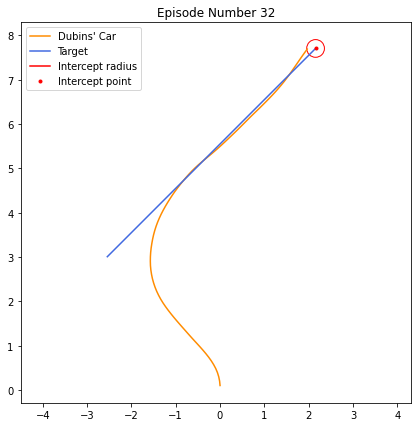

The target has been captured
Episode * 32 * Avg Reward is ==> -55613.26193725515


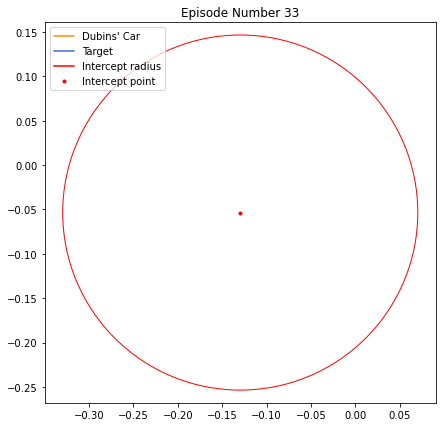

Episode * 33 * Avg Reward is ==> -54188.632457945416


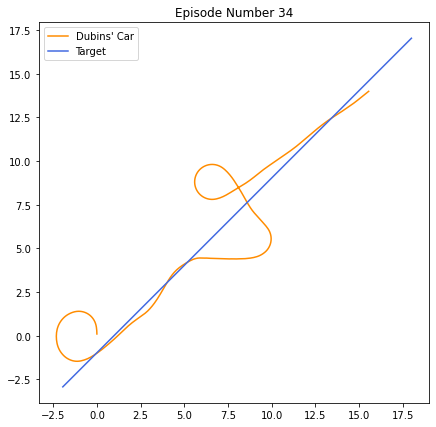

Episode * 34 * Avg Reward is ==> -52807.543430571364


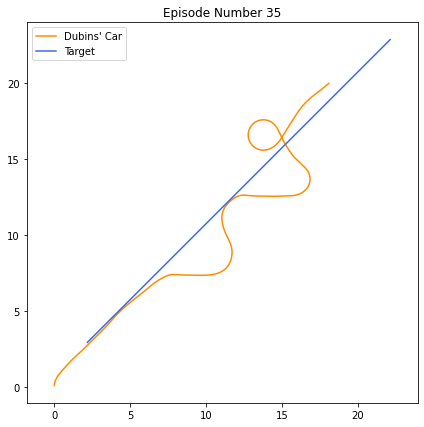

The target has been captured
Episode * 35 * Avg Reward is ==> -51348.8121783134


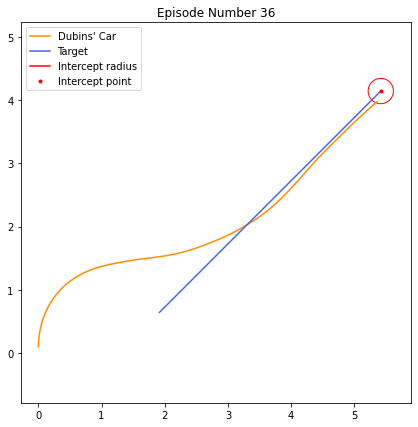

The target has been captured
Episode * 36 * Avg Reward is ==> -49963.47848384653


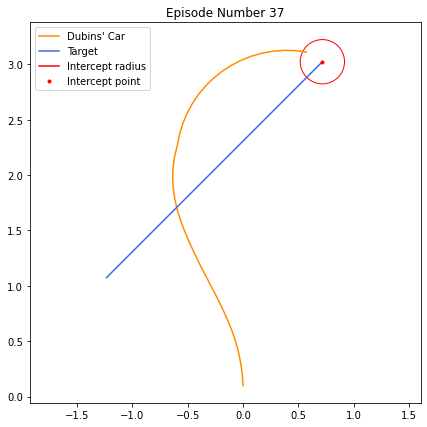

Episode * 37 * Avg Reward is ==> -48704.74410818266


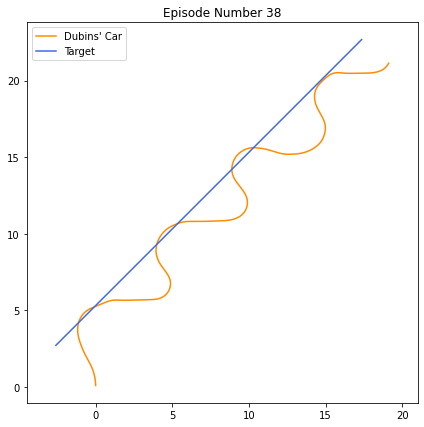

The target has been captured
Episode * 38 * Avg Reward is ==> -47467.08673598912


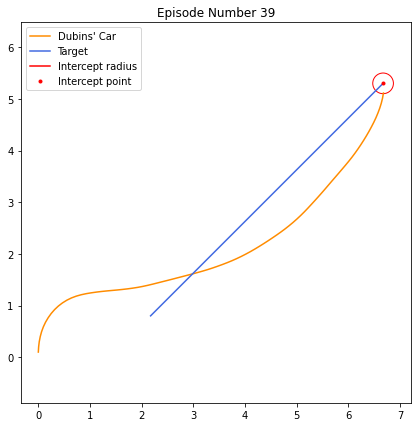

The target has been captured
Episode * 39 * Avg Reward is ==> -46288.367893208975


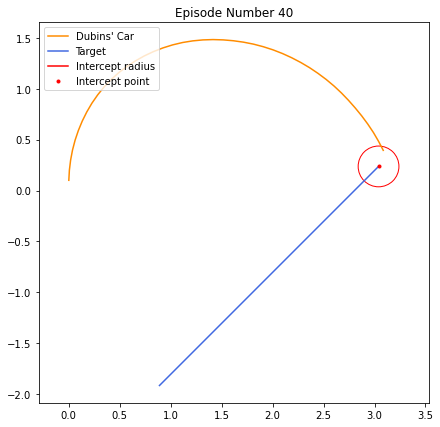

The target has been captured
Episode * 40 * Avg Reward is ==> -45187.736219302715


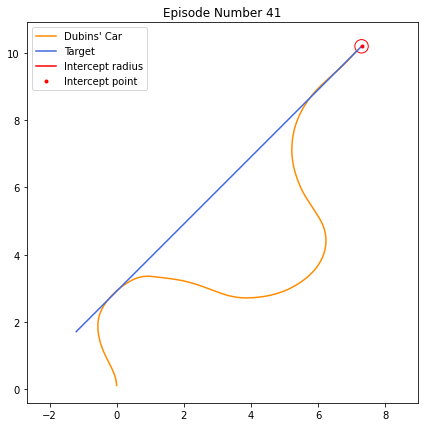

The target has been captured
Episode * 41 * Avg Reward is ==> -44115.706377417366


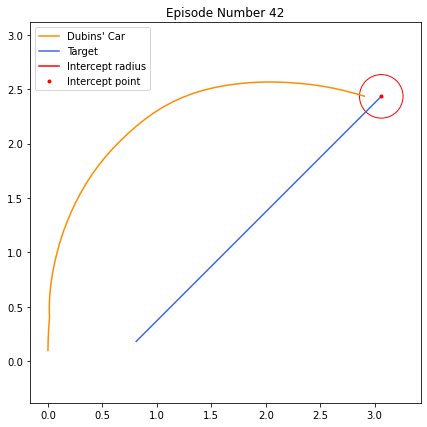

Episode * 42 * Avg Reward is ==> -43209.56346070356


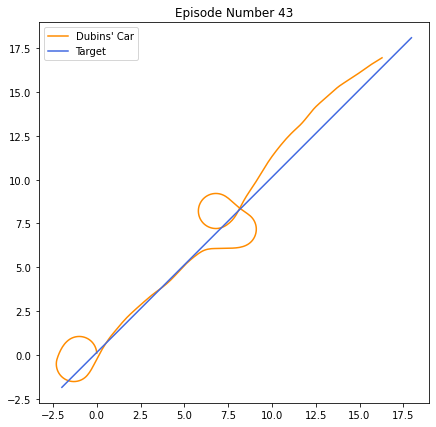

Episode * 43 * Avg Reward is ==> -42274.181285348044


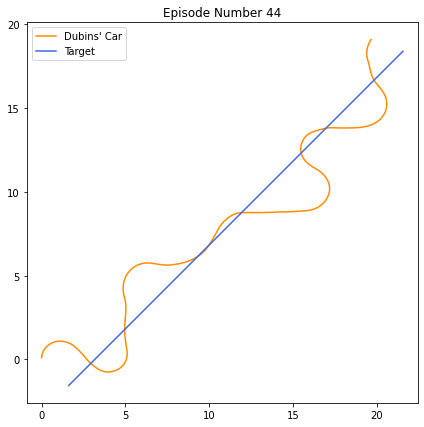

Episode * 44 * Avg Reward is ==> -41744.53225084716


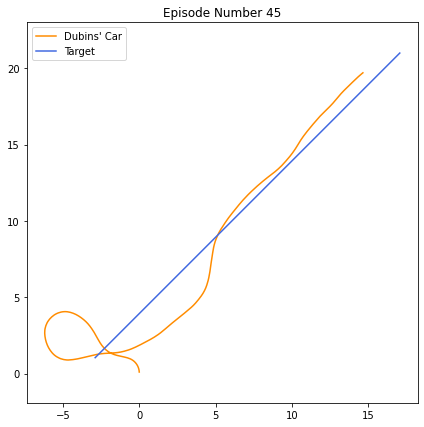

The target has been captured
Episode * 45 * Avg Reward is ==> -41074.26733629117


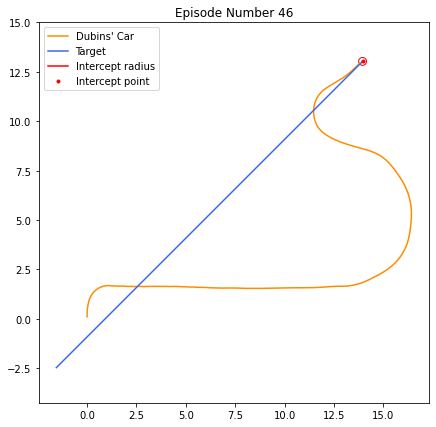

Episode * 46 * Avg Reward is ==> -40435.750120972494


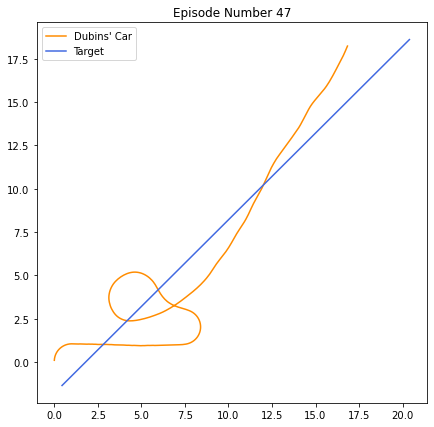

The target has been captured
Episode * 47 * Avg Reward is ==> -39603.989856323


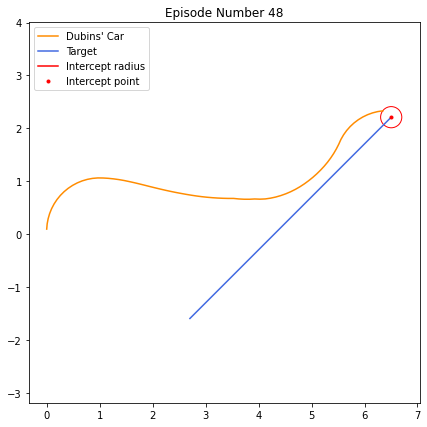

Episode * 48 * Avg Reward is ==> -39143.421347874355


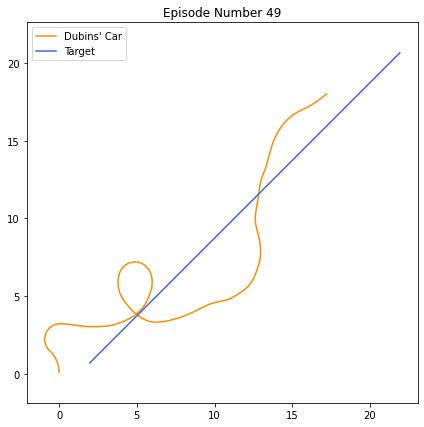

The target has been captured
Episode * 49 * Avg Reward is ==> -38374.6620591804


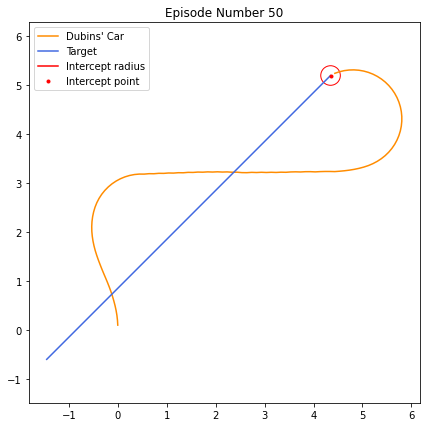

Episode * 50 * Avg Reward is ==> -37976.295843375374


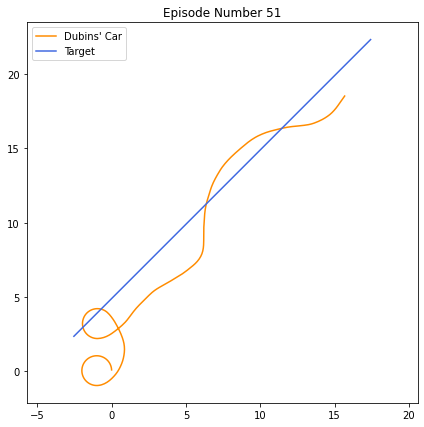

Episode * 51 * Avg Reward is ==> -37639.04212127934


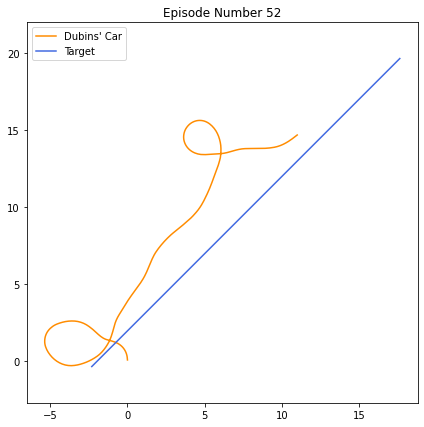

Episode * 52 * Avg Reward is ==> -37059.861560444675


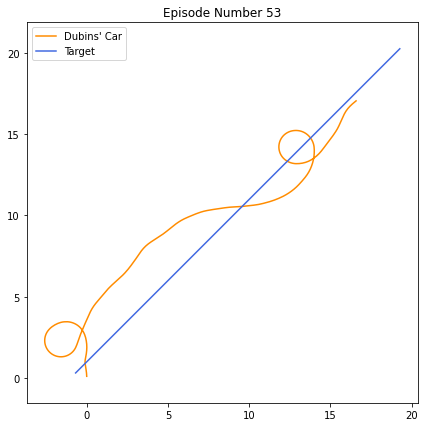

Episode * 53 * Avg Reward is ==> -36578.25494949106


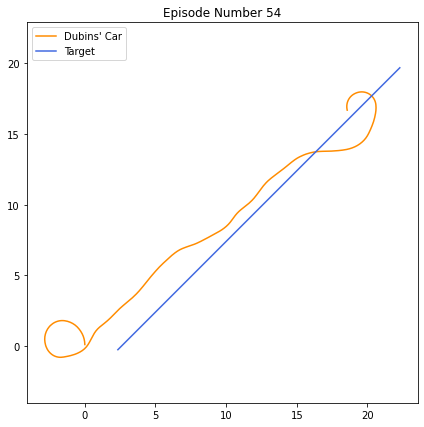

Episode * 54 * Avg Reward is ==> -36175.86628116195


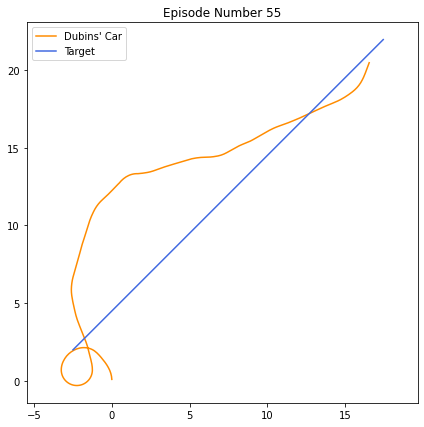

Episode * 55 * Avg Reward is ==> -35721.01648340366


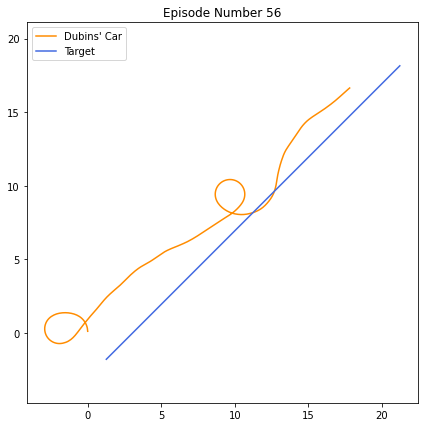

Episode * 56 * Avg Reward is ==> -35494.230471419476


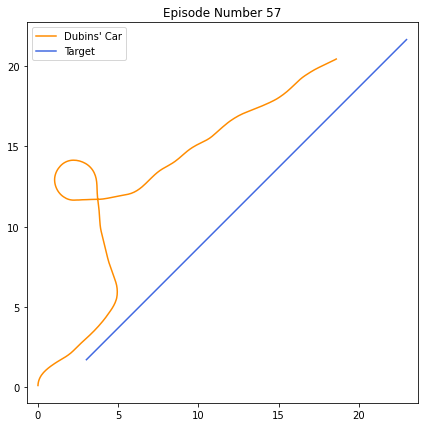

Episode * 57 * Avg Reward is ==> -35015.43428262528


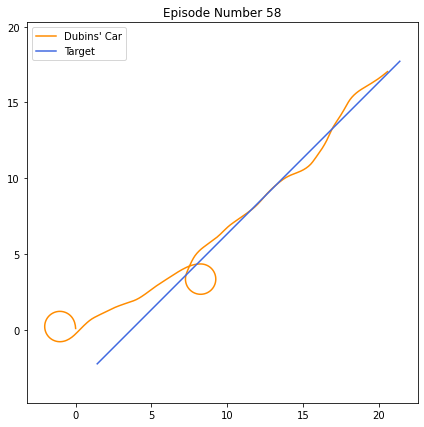

Episode * 58 * Avg Reward is ==> -34668.3988294642


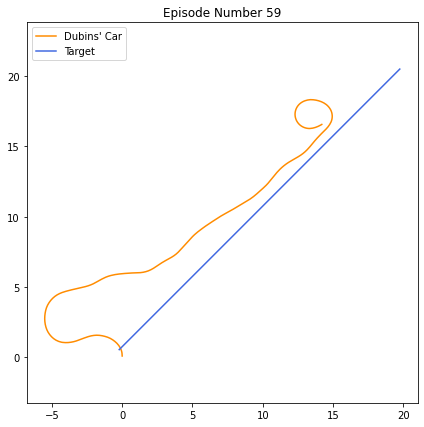

Episode * 59 * Avg Reward is ==> -34211.00394564734


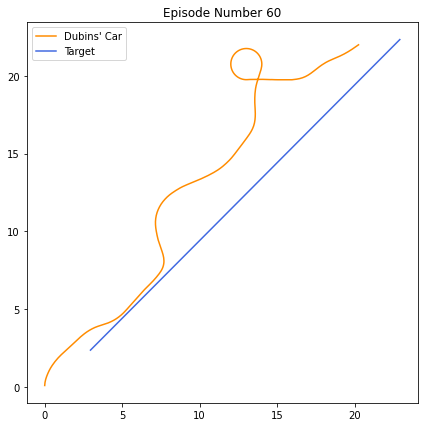

The target has been captured
Episode * 60 * Avg Reward is ==> -33846.59228999382


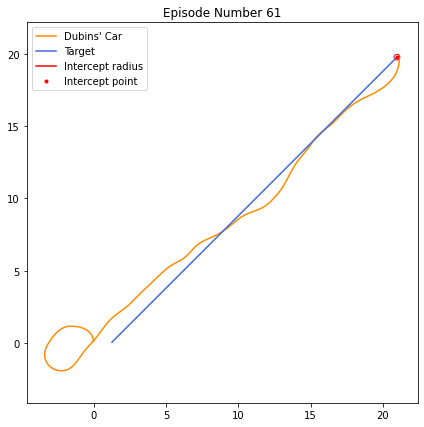

Episode * 61 * Avg Reward is ==> -33398.47963581448


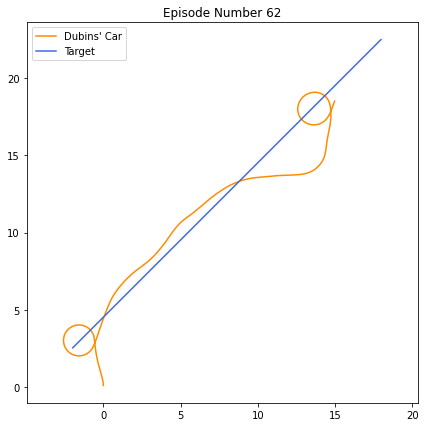

The target has been captured
Episode * 62 * Avg Reward is ==> -32944.38055474236


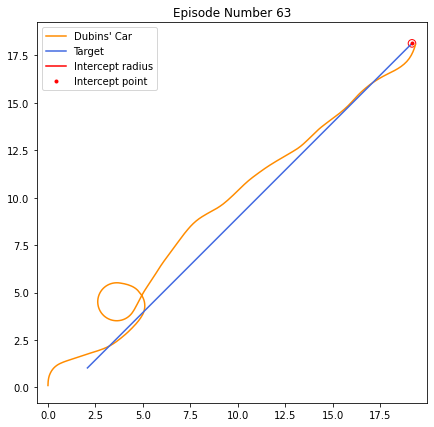

Episode * 63 * Avg Reward is ==> -32500.897504449917


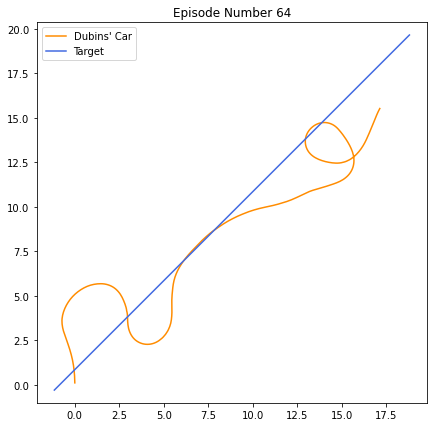

Episode * 64 * Avg Reward is ==> -32169.985736534687


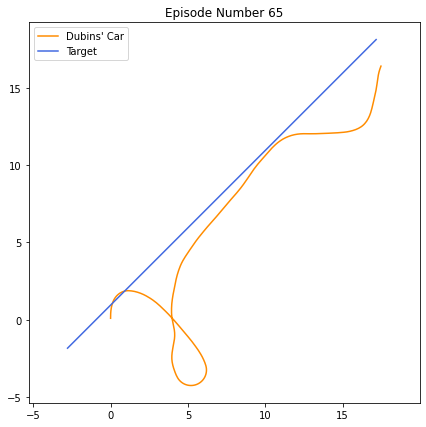

The target has been captured
Episode * 65 * Avg Reward is ==> -31688.69442228768


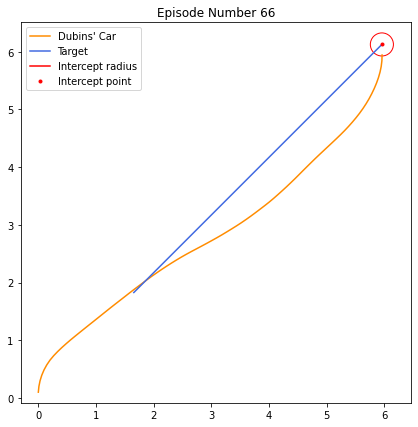

The target has been captured
Episode * 66 * Avg Reward is ==> -31217.1010579696


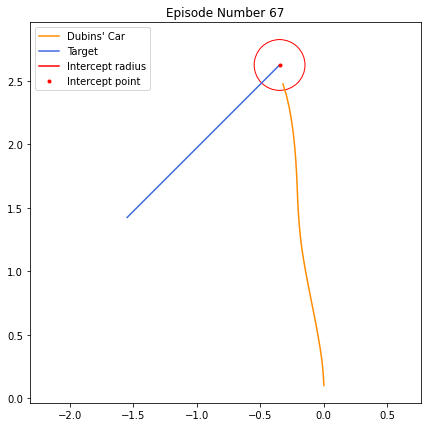

The target has been captured
Episode * 67 * Avg Reward is ==> -30758.050472245654


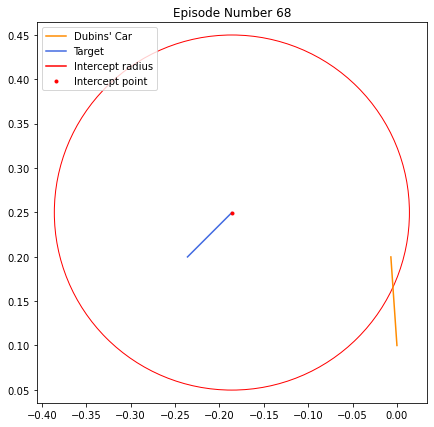

Episode * 68 * Avg Reward is ==> -30371.954074183035


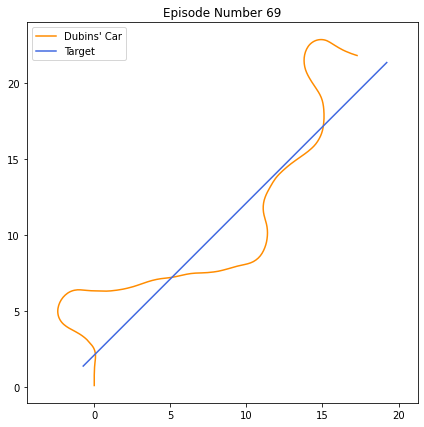

Episode * 69 * Avg Reward is ==> -30040.124456597718


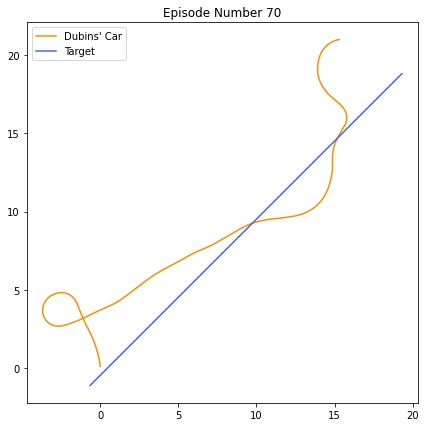

The target has been captured
Episode * 70 * Avg Reward is ==> -29625.291839209898


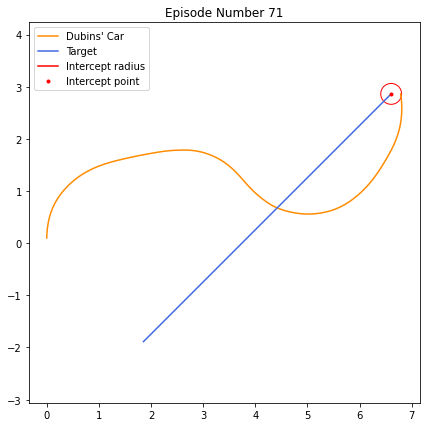

The target has been captured
Episode * 71 * Avg Reward is ==> -29218.61654968385


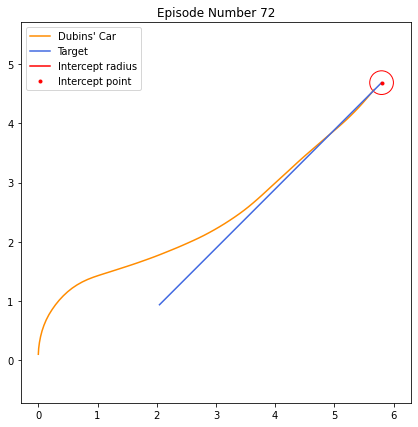

The target has been captured
Episode * 72 * Avg Reward is ==> -28835.32017017071


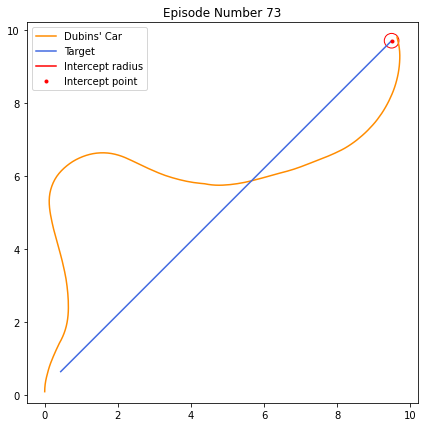

The target has been captured
Episode * 73 * Avg Reward is ==> -28473.35952943252


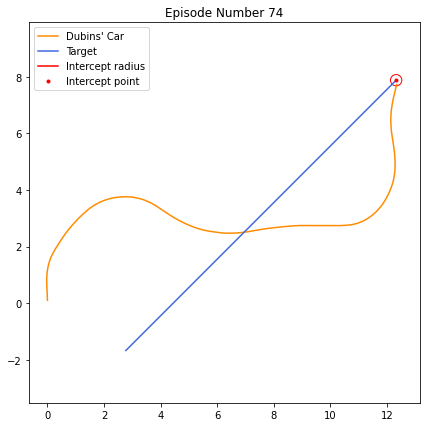

Episode * 74 * Avg Reward is ==> -28215.10051513986


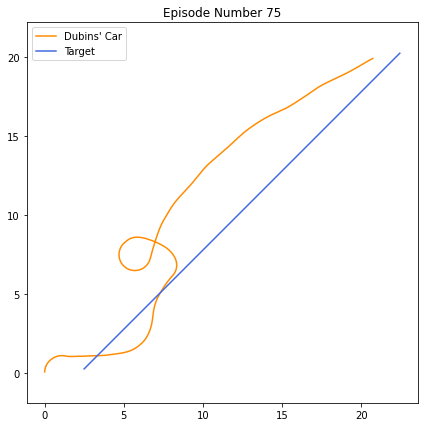

The target has been captured
Episode * 75 * Avg Reward is ==> -27874.92190842547


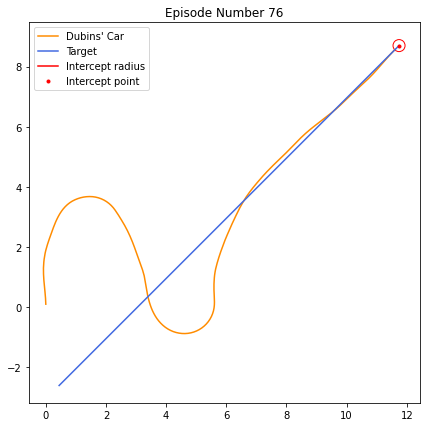

The target has been captured
Episode * 76 * Avg Reward is ==> -27526.4273073052


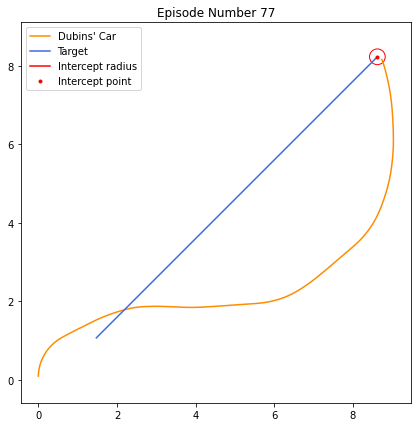

Episode * 77 * Avg Reward is ==> -27216.583525227492


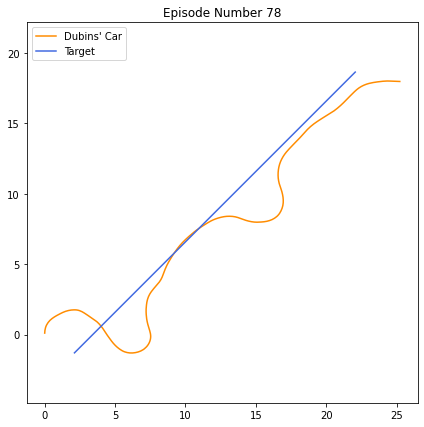

The target has been captured
Episode * 78 * Avg Reward is ==> -26877.714611185685


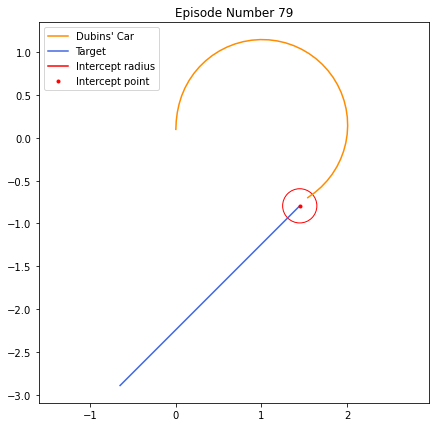

The target has been captured
Episode * 79 * Avg Reward is ==> -26584.888128374492


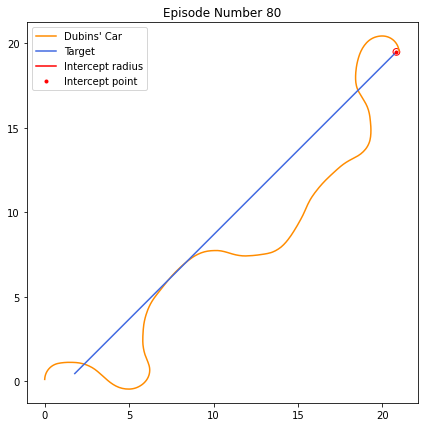

The target has been captured
Episode * 80 * Avg Reward is ==> -26274.216279086697


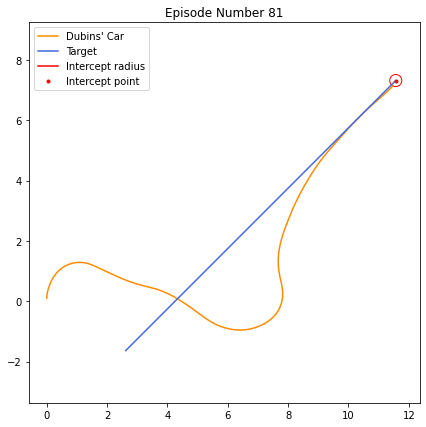

The target has been captured
Episode * 81 * Avg Reward is ==> -25955.740753205202


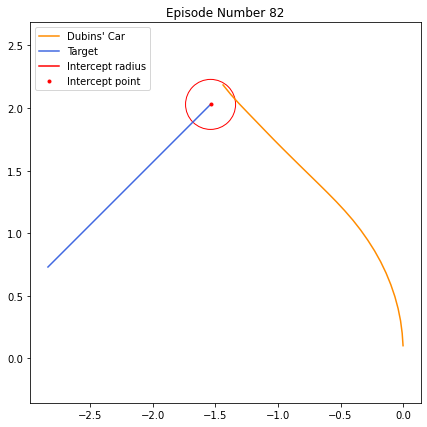

Episode * 82 * Avg Reward is ==> -25686.232859000243


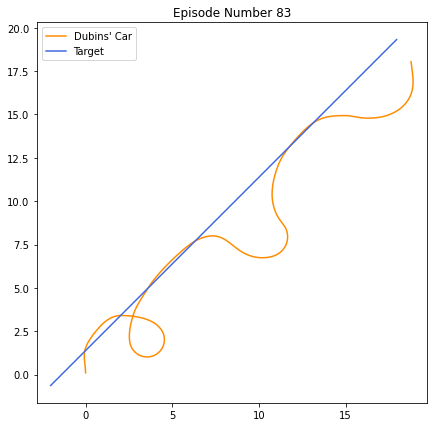

Episode * 83 * Avg Reward is ==> -25472.39874379827


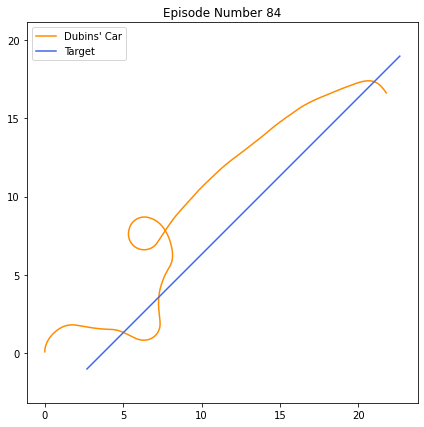

The target has been captured
Episode * 84 * Avg Reward is ==> -25192.345996122556


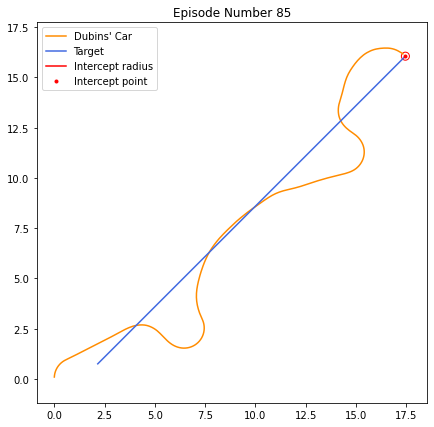

Episode * 85 * Avg Reward is ==> -24958.859201113803


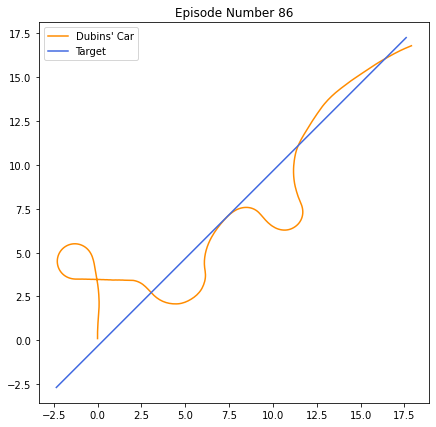

The target has been captured
Episode * 86 * Avg Reward is ==> -24680.391354481555


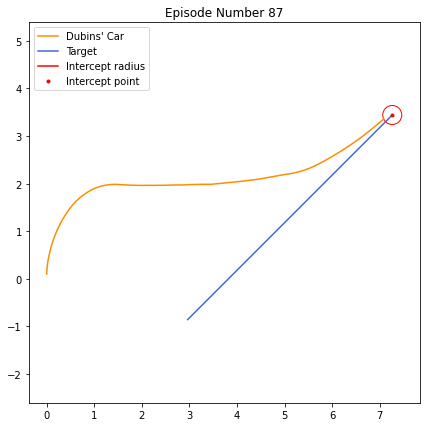

Episode * 87 * Avg Reward is ==> -24450.037255082523


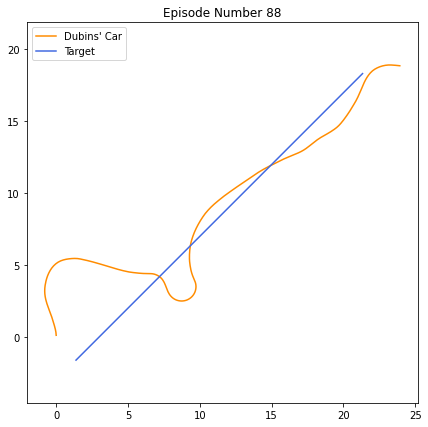

Episode * 88 * Avg Reward is ==> -24431.155274642766


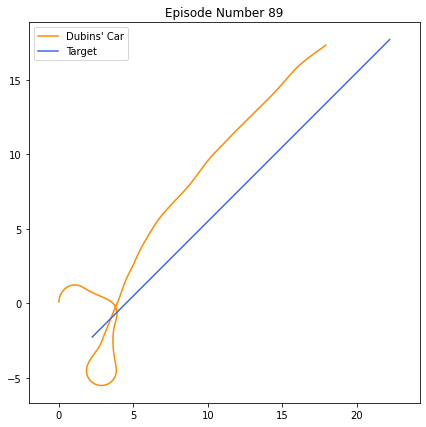

The target has been captured
Episode * 89 * Avg Reward is ==> -24176.518060480976


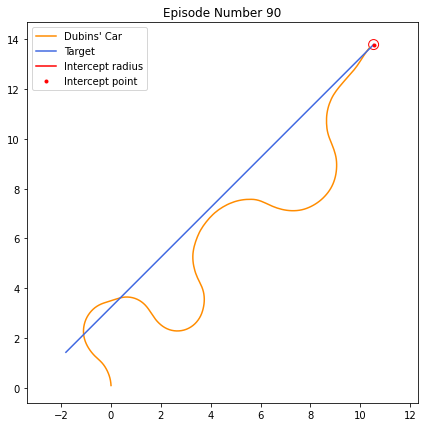

The target has been captured
Episode * 90 * Avg Reward is ==> -23923.657932060836


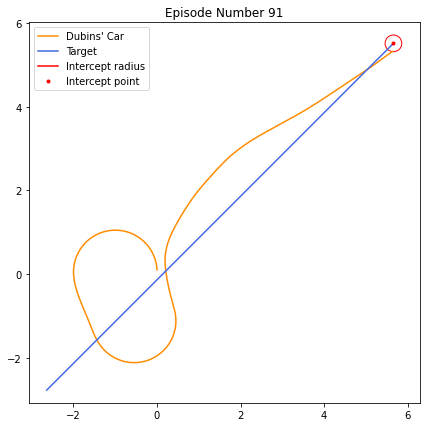

Episode * 91 * Avg Reward is ==> -23734.862075079094


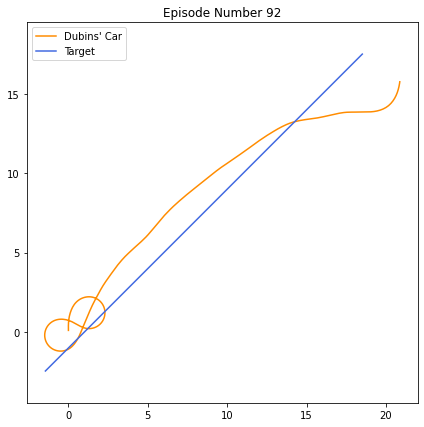

The target has been captured
Episode * 92 * Avg Reward is ==> -23486.584181770348


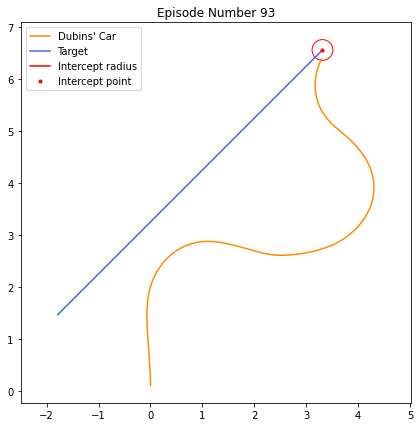

Episode * 93 * Avg Reward is ==> -23281.941405895534


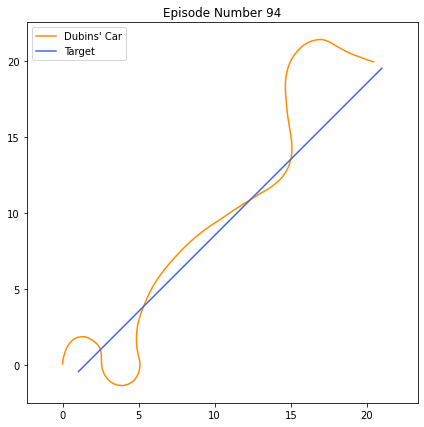

The target has been captured
Episode * 94 * Avg Reward is ==> -23048.136032148053


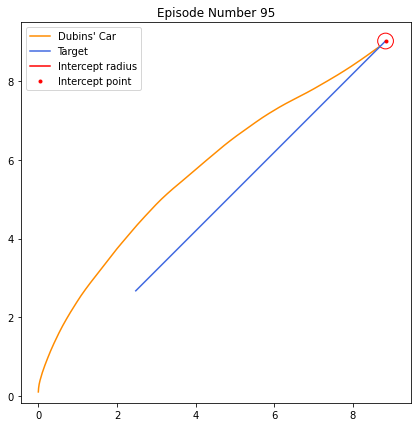

The target has been captured
Episode * 95 * Avg Reward is ==> -22820.765288327548


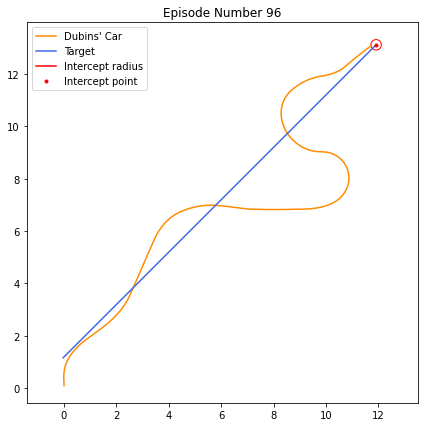

The target has been captured
Episode * 96 * Avg Reward is ==> -22679.59417429959


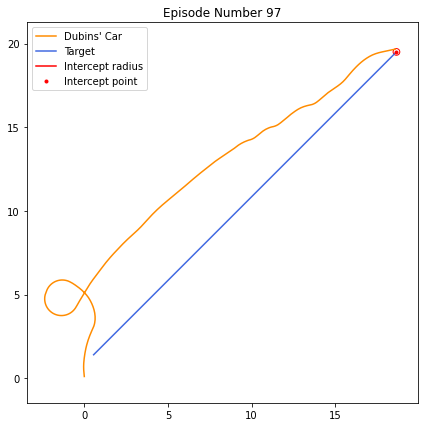

The target has been captured
Episode * 97 * Avg Reward is ==> -22462.23002071166


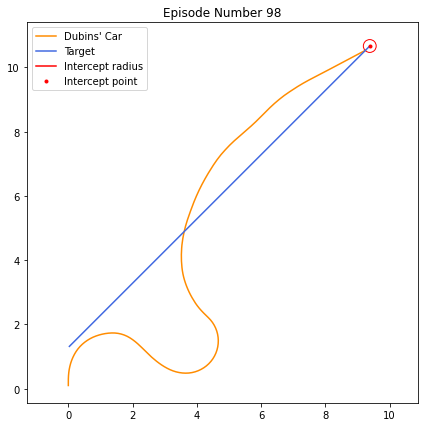

The target has been captured
Episode * 98 * Avg Reward is ==> -22239.679337398327


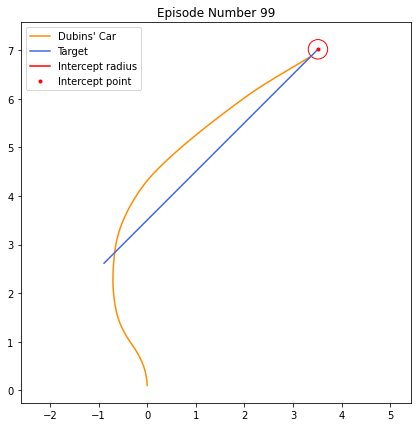

The target has been captured
Episode * 99 * Avg Reward is ==> -22042.794475816536


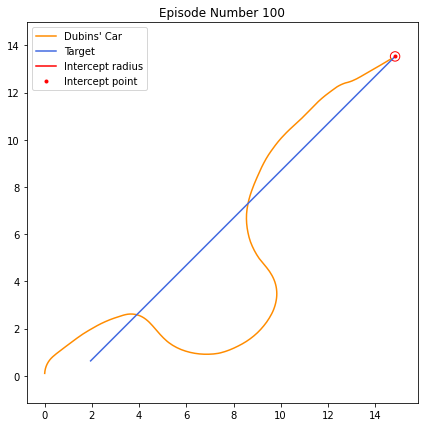

The target has been captured
Episode * 100 * Avg Reward is ==> -21851.74421921993


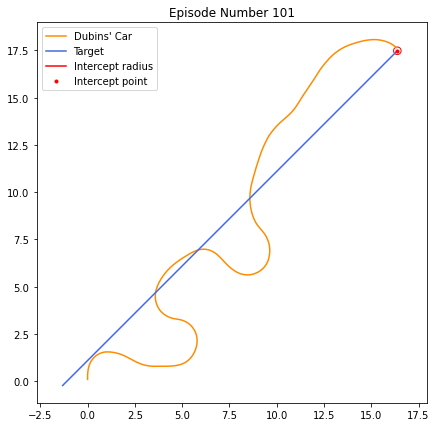

Episode * 101 * Avg Reward is ==> -21677.99483574924


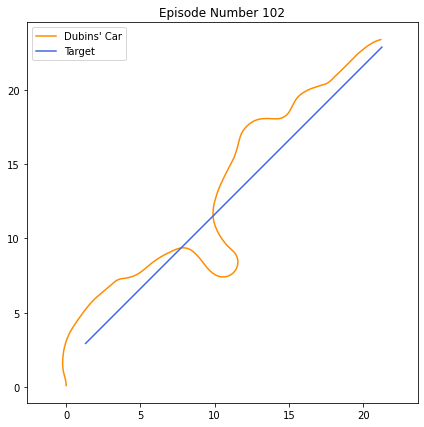

Episode * 102 * Avg Reward is ==> -21504.94816348547


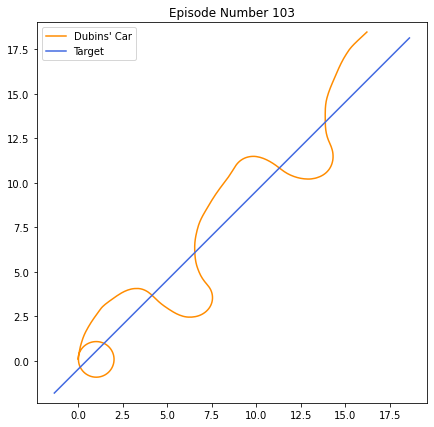

Episode * 103 * Avg Reward is ==> -21353.682559456927


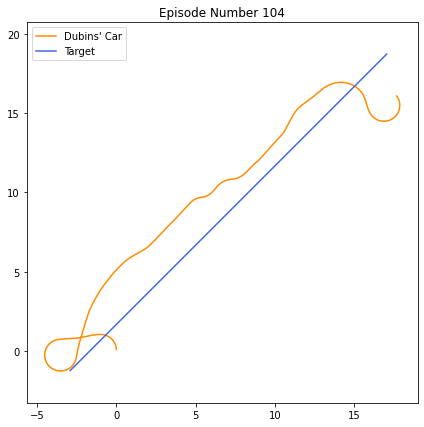

The target has been captured
Episode * 104 * Avg Reward is ==> -21173.352333284125


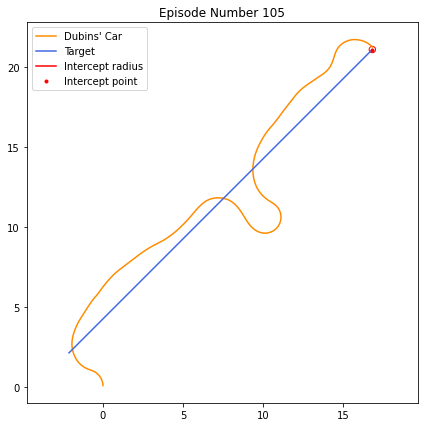

The target has been captured
Episode * 105 * Avg Reward is ==> -20975.774726456482


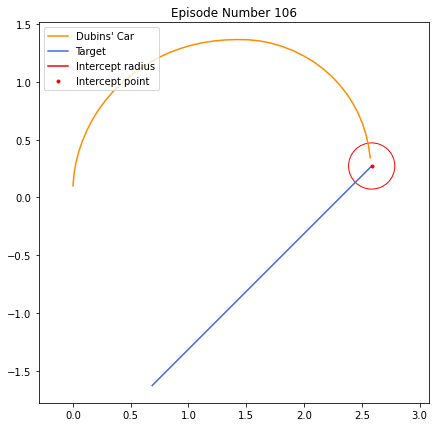

The target has been captured
Episode * 106 * Avg Reward is ==> -20782.348245247755


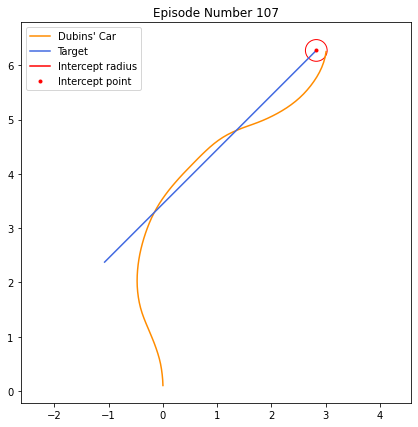

The target has been captured
Episode * 107 * Avg Reward is ==> -20611.157221623693


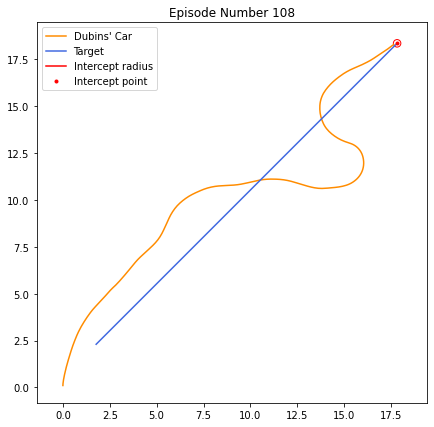

The target has been captured
Episode * 108 * Avg Reward is ==> -20445.951974433887


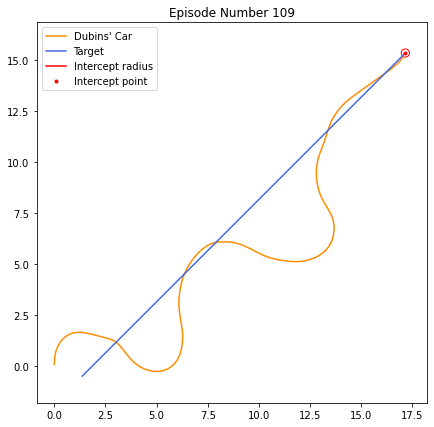

The target has been captured
Episode * 109 * Avg Reward is ==> -20268.208224053982


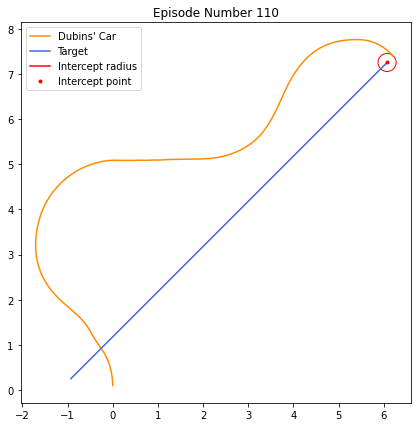

Episode * 110 * Avg Reward is ==> -20116.069143068842


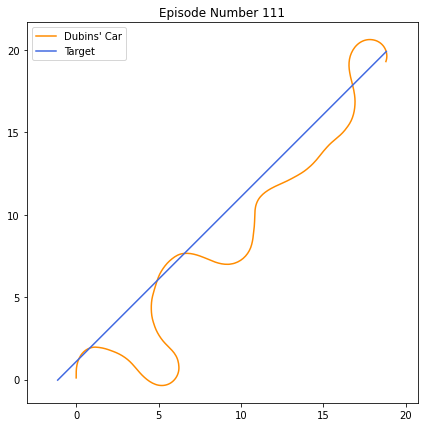

Episode * 111 * Avg Reward is ==> -19970.968535959073


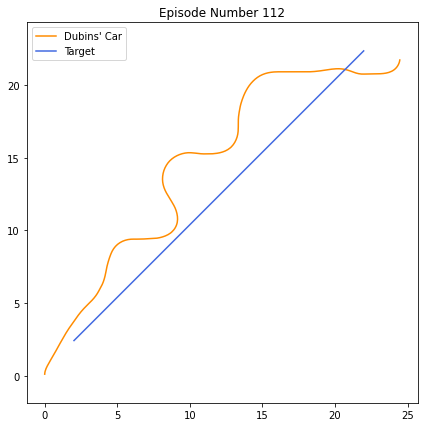

KeyboardInterrupt: 

In [25]:
ep_reward_list = []
ep_actor_loss_list = []
ep_critic_loss_list = []
# To store average reward history of last few episodes
avg_reward_list = []
#lists with actor's / critic's losses
critic_loss_list = []
actor_loss_list = []

# Takes about 40-50 min to train (use GPU for training)
for ep in range(num_episodes):
    cor0 = (np.random.uniform(-3,3) , np.random.uniform(-3,3))
    sys_state = [0 , 0 , np.pi/2 , cor0[0] , cor0[1]]
    alpha = angle(sys_state)
    red_tet = sys_state[2] - alpha
    red_state = (leng(sys_state), 0, red_tet)
    episodic_reward = 0
    episodic_loss_actor = 0
    episodic_loss_critic = 0
    
    xc = []
    yc = []
    xce = []
    yce = []
    
    t = 0
    dt = 0.1
    
    index_capture = 0 #if 0, then there is no interception; if 1, the interception occurred
    #while True:
    
    for i in range(num_steps):
        if leng(sys_state) > R0:
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(red_state), 0)

            action = policy(tf_prev_state, ou_noise)
            
            # Recieve state and reward from environment.
            new_state, new_red_state = transition(sys_state, float(action[0]), t, cor0)
            rew = reward(new_state)
            
            buffer.record((red_state , action, rew, new_red_state))
            episodic_reward += rew
            buffer.learn()
            update_target(tau)
        
            actor_los = tf.reshape(buffer.get_list_actor(), []).numpy()
            critic_los = tf.reshape(buffer.get_list_critic(), []).numpy()
        
            episodic_loss_actor += actor_los
            episodic_loss_critic += critic_los
        
            t += dt
            red_state = new_red_state
            sys_state = new_state
            xc.append(sys_state[0])
            yc.append(sys_state[1])
        
            xce.append(sys_state[3])
            yce.append(sys_state[4])
        
            index_capture = 0
        else:
            print('The target has been captured')
            index_capture = 1
            break
        
    xc1 = [sys_state[3]]
    yc1 = [sys_state[4]]

    ep_reward_list.append(episodic_reward)
    
    ep_actor_loss_list.append(episodic_loss_actor)
    ep_critic_loss_list.append(episodic_loss_critic)
    
    # Mean of last 40 episodes
    avg_actor_loss = np.mean(ep_actor_loss_list[-num_episodes:])
    avg_critic_loss = np.mean(ep_critic_loss_list[-num_episodes:])
    
    critic_loss_list.append(avg_critic_loss)
    actor_loss_list.append(avg_actor_loss)
    
    avg_reward = np.mean(ep_reward_list[-num_episodes:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.axis('equal')
    #plt.gca().set_aspect('equal', adjustable='box')
    
    #title = "Episode Number" ep+1
    title = "{} {}".format("Episode Number", ep+1)
    
    ax.plot(xc, yc, color = 'darkorange', label = 'Dubins\' Car')
    ax.plot(xce, yce, color = 'royalblue', label = 'Target')
    
    if index_capture == 1:
        circle = matplotlib.patches.Circle((xc1, yc1), radius=R0, fill=False, color="r")
        ax.plot(xc1, yc1, color = 'red', label = 'Intercept radius')
        ax.plot(xc1, yc1, '.', color = 'red', label = 'Intercept point')
        ax.add_patch(circle)
    
    ax.legend(loc = 'upper left')
    
    plt.title(title)
    
    #plt.plot(xc,yc)
    #plt.plot(xce,yce)
    #plt.plot(xc1,yc1,'.')
    plt.show()

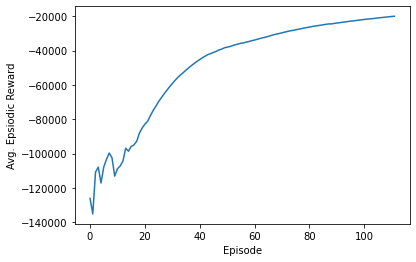

In [26]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

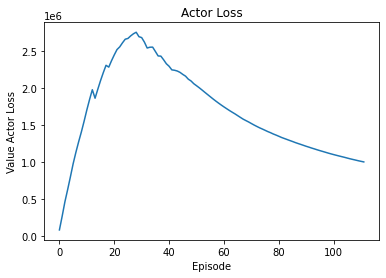

In [27]:
plt.plot(actor_loss_list)
plt.title("Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Value Actor Loss")
plt.show()

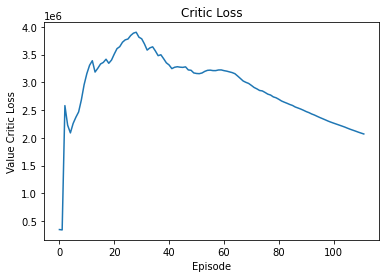

In [28]:
plt.plot(critic_loss_list)
plt.title("Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Value Critic Loss")
plt.show()

In [30]:
# use if you want to save or load weights for your NN
actor_model.load_weights('./checkpoints/lr_0.001')

In [31]:
#actor_model.save_weights('./checkpoints/lr_0.002')
#actor_model.load_weights('./checkpoints/my_checkpoint_26_01_400ep')

### Analytical solution

Here I redefine some parameters. This is done for the convenience of code control and constants.

In [32]:
# set a vector that will contain arrays of the movement of the Dubins machine and the target
pos_vec = [[],[],[],[],[]]

V_p, U_p = 1, 1 # speed of the Dubins machine (car)
t0 = 0 # initial time
#posP = array(cor0_p) # array of initial coordinates of the car

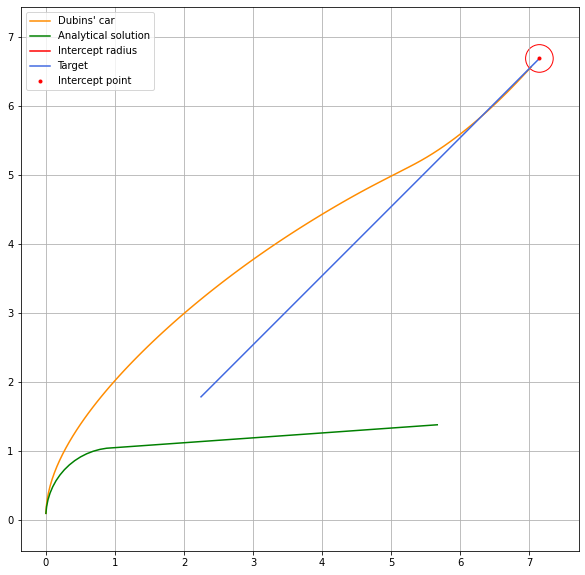

Optimal time: 6.219994440254654
NN time: 9.9
time erorr: 37.17177333076108 %


In [33]:
def xE(t):
    return Vx_e * t + cor0_e[0]

def yE(t):
    return Vy_e * t + cor0_e[1]

def ρB_CS(t, x, y):
    τ1 = (arctg2(y, 1-abs(x)) + arccos(1/sqrt((1-abs(x))**2 + y**2))) % (2*pi)
    τ2 = (arctg2(y, 1-abs(x)) - arccos(1/sqrt((1-abs(x))**2 + y**2))) % (2*pi)
    τ = array([τ1, τ2, 0, t])
    τ = τ[τ <= t]
    ρ = sqrt((abs(x) - x_RS(τ, t))**2 + (y - y_RS(τ, t))**2)
    return ρ.min()
def ρB_CC(t, x, y):
    a = -(y + sin(t/3))
    b = 3*(1+abs(x)) + cos(t/3)
    c = 3*y - sin(t/3)
    d = -(1+abs(x)) + cos(t/3)
    ξ = roots([a, b, c, d]) 
    τ = (t/3 - 2*arctan(real(ξ))) % (2*pi)
    τ = append(τ[τ <= t], [0, t])
    ρ = sqrt((abs(x) - x_LR(τ, t))**2 + (y - y_LR(τ, t))**2)
    return ρ.min()
def ρB(t, x, y):
    return min(ρB_CS(t, x, y), ρB_CC(t, x, y))
def convergent_estimate(t, xE, yE, v_max):
    t = t + ρB(t, xE(t), yE(t))/(1 + v_max)
    return t

def conv_est(t, xE, yE, v, ε):
    n = 0
    t_prev = float('-inf')
    δ = ε/(1 + v)
    while t - t_prev > δ:
        t_prev = t
        n += 1
        t = convergent_estimate(t, xE, yE, v)
    return n, t

# T - intercept time
N, T = conv_est(0, xE, yE, V_e, ε)
V_cs = V_CS(xE(T), yE(T))
V_cc_m = V_CC_minus(xE(T), yE(T))
V_cc_p = V_CC_plus(xE(T), yE(T))

def min_V(v_CS, v_CC_minus, v_CC_plus, T):
    V_CS_T = abs(v_CS - T)
    V_CC_minus_T = abs(v_CC_minus - T)
    V_CC_plus_T = abs(v_CC_plus - T)
    V_list = [V_CS_T, V_CC_minus_T, V_CC_plus_T]
    minor = V_list[0]
    for V in V_list:
        if V < minor:
            minor = V
    return V_list.index(minor)

def teta_CS_func(t):
    state = sqrt(abs((1 - abs(xE(t))) ** 2 + yE(t) ** 2 - 1)) #может быть под корнем отрицательное число!
    alfa_C = (1 - abs(xE(t)) + yE(t) * state) / (state ** 2 + 1)
    alfa_S = (yE(t) - (1 - abs(xE(t))) * state) / (state ** 2 + 1)
    if alfa_S >= 0:
        teta_CS = arccos(alfa_C)
    else:
        teta_CS = 2 * pi - arccos(alfa_C)
    return teta_CS

#teta_CS_func(T)
def u_CS_func(t):
    teta_CS = teta_CS_func(T) #находим teta_CS от Т
    return np.where((t < teta_CS) & (xE(T) != 0), [-np.sign(xE(T))],
                    (np.where((t < teta_CS) & (xE(T) == 0), [1.], [0])))
    
def teta_CC_pol(t):
    alfa = (5 - (1 + abs(xE(t))) ** 2 - yE(t) ** 2) / 4
    return arccos(((1 + abs(xE(t))) * (2 - alfa) +
                               yE(t) * sqrt(1 - alfa ** 2))/((1 + abs(xE(t))) ** 2 + yE(t) ** 2))

def teta_CC_min(t):
    alfa = (5 - (1 + abs(xE(t))) ** 2 - yE(t) ** 2) / 4
    return arccos(((1 + abs(xE(t))) * (2 - alfa) -
                               yE(t) * sqrt(1 - alfa ** 2))/((1 + abs(xE(t))) ** 2 + yE(t) ** 2))
def u_CC_pol_func(t):
    teta_CC = teta_CC_pol(T) #находим teta_CC от Т
    return np.where((t < teta_CC) & (xE(T) != 0), [np.sign(xE(T))],
                    (np.where((t >= teta_CC) & (xE(T) != 0), [-np.sign(xE(T))],
                              (np.where((t < teta_CC) & (xE(T) == 0), [1.], [-1.])))))

def u_CC_min_func(t):
    teta_CC = teta_CC_min(T) #находим teta_CC от Т
    return np.where((t < teta_CC) & (xE(T) != 0), [np.sign(xE(T))],
                    (np.where((t >= teta_CC) & (xE(T) != 0), [-np.sign(xE(T))],
                              (np.where((t < teta_CC) & (xE(T) == 0), [1.], [-1.])))))
def u_opt(t0):
    index = min_V(V_cs, V_cc_m, V_cc_p, T)
    if index == 0:    
        return u_CS_func(t0)
    elif index == 1:
        return u_CC_min_func(t0)
    elif index == 2:
        return u_CC_pol_func(t0)
def compute_len(posP,posE):
    return sqrt((posP[0]-posE[0])**2+(posP[1]-posE[1])**2)

def policy_test(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy()
    return [sampled_actions]

index = min_V(V_cs, V_cc_m, V_cc_p, T)
posP =  [0, 0, np.pi/2]
t0 = 0
dt  = 0.1
while t0 <= T:
    #print(posP)
    posE = [xE(t0), yE(t0)]
    #posE_arr = array(posE)
    #print(u_opt(t))
    velo = np.array([np.cos(posP[2]),np.sin(posP[2]),float(u_opt(t0))])
    posP = posP + velo*dt
    if compute_len(posP,posE)<=2*ε:
        print('ez_game')
    t0 += dt
    #posP_arr = array(posP)
    pos_vec[0].append(posP[0]) #xP
    pos_vec[1].append(posP[1]) #yP
#cor0 = (np.random.uniform(-10,10) , np.random.uniform(-10,10))
sys_state = [0 , 0 , np.pi/2 , cor0[0] , cor0[1]]
alpha = angle(sys_state)
red_tet = sys_state[2] - alpha
red_state = (leng(sys_state), 0, red_tet)
episodic_reward = 0
xc = []
yc = []
xce = []
yce = []
t = 0
dt = 0.1
#while True:
for i in range(num_steps):
    if leng(sys_state) > R0:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(red_state), 0)
        
        action = policy_test(tf_prev_state, ou_noise)
        
        new_state, new_red_state = transition(sys_state, float(action[0]), t, cor0)
        
        #rew = reward(new_state)
        t += dt
        red_state = new_red_state
        sys_state = new_state
        xc.append(sys_state[0])
        yc.append(sys_state[1])
        
        xce.append(sys_state[3])
        yce.append(sys_state[4])
    else:
        break
xc1 = [sys_state[3]]
yc1 = [sys_state[4]]


fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('equal')
#plt.gca().set_aspect('equal', adjustable='box')
plt.grid()

ax.plot(xc, yc, color = 'darkorange', label = 'Dubins\' car')
ax.plot(pos_vec[0], pos_vec[1], color = 'green', label = 'Analytical solution')
ax.plot(xce[0], yce[0], color = 'red', label = 'Intercept radius')

ax.plot(xce, yce, color = 'royalblue', label = 'Target')
#plt.title('Optimal trajectories')
ax.plot(xc1, yc1, '.', color = 'red', label = 'Intercept point')
circle = matplotlib.patches.Circle((xc1, yc1), radius=R0, fill=False, color="r")
ax.add_patch(circle)
#plt.text(-1.7, 1.02, "Intercept radius", horizontalalignment="center")
ax.legend(loc = 'upper left')

plt.show() 


#plt.plot(xc,yc)
#plt.plot(xce,yce)
#plt.plot(pos_vec[0],pos_vec[1])
#plt.plot(xc1,yc1,'.')
#title = 'Сomparison of trajectories'
#plt.title(title)
#plt.show()
#print('Opt time:',len(np.array(pos_vec[0]))*0.1)
print('Optimal time:', T)
print('NN time:', len(xc)*0.1)
print('time erorr:', abs(len(xc)*0.1 - T) / max(len(xc)*0.1, T) * 100, '%')